### Girvan-Newman Partitioning

The purpose of this homework is to teach you 
- about what the Girvan-Newman partitioning algorithm does
- how to use the modularity metric to find a good partition
- practice using dendrograms to understand partioning

The tutorial will use the karate class graph to demonstrate different steps in the process, and the homework will ask you to apply these steps to a few different graphs. The homework will also ask you to interpret what you are seeing for the different graphs.

---

#### Utilities

As usual, we'll start by defining some utilities for showing graphs and partitions.

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Hashable, Union, Literal
from numpy import linalg as linalg
from matplotlib.axes import Axes

####################################
## Create datatype that specifies ##
## the style of the graph display ##
####################################
PlotType = Literal[
    "GRAPHVIZ",
    "CIRCULAR",
    "SPRING",
    "DOT"
]

#################################
## Show graph with node labels ##
## in a chosen set of axes     ##
#################################
def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None,
               node_color: Union[None, list[str]] = None,
               plot_style: PlotType = "GRAPHVIZ"
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()
    if node_color is None:
        node_color = ['y' for _ in G.nodes]
    node_positions: dict[Hashable, tuple[float, float]] = dict()
    if plot_style == "GRAPHVIZ":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='neato')
    elif plot_style == "DOT":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='dot')
    elif plot_style == "SPRING":
        node_positions = nx.spring_layout(G)
    else:
        node_positions = nx.circular_layout(G)

    nx.draw(G, 
        node_positions, 
        node_color = node_color, 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    
    axes.set_title(title)
    axes.set_aspect('equal')

    # Return the node positions in case I want to use them again
    return node_positions


Show the karate class network

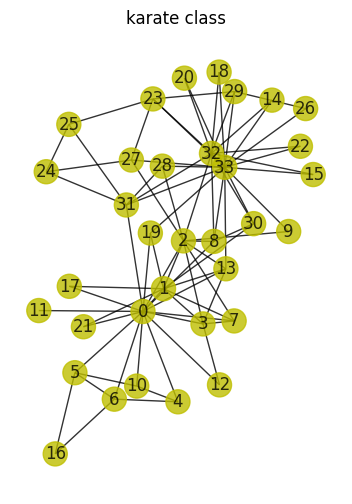

In [28]:
karate_class: nx.Graph = nx.karate_club_graph()
_ = plt.figure(figsize=(6,6))
axes = plt.gca()
_ = show_graph(karate_class, title = "karate class", axes = axes)

---

#### Girvan-Newman partitioning

The Girvan-Newman partitioning algorithm greedily removes the edge with highest _edge betweenness_. The algorithm stops when a partition with maximum modularity is found (with reasonable confidence). 

We'll use the `nx.girvan_newman` to find all possible communities which can be obtained by greedily removing the edge with highes edge betweenness. See [girvan_newman](!https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html).

In [29]:
from typing import Iterator, Tuple
partitions: Iterator = nx.community.girvan_newman(karate_class)
partition_list: list[Tuple[set, ]] = list(partitions)
print(partition_list)
for communities in partition_list:
    print(tuple(sorted(c) for c in communities))

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {12}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2

Each line above represents a different possible partitioning of the vertices into groups. The first line partitions vertices into two groups, the second line into three groups, and the last line into one-group-per vertex.

---

Let's take a peak at the first partition. We'll display the groups by separating vertices into different colors, with all the vertices in a single group assigned the same color. 

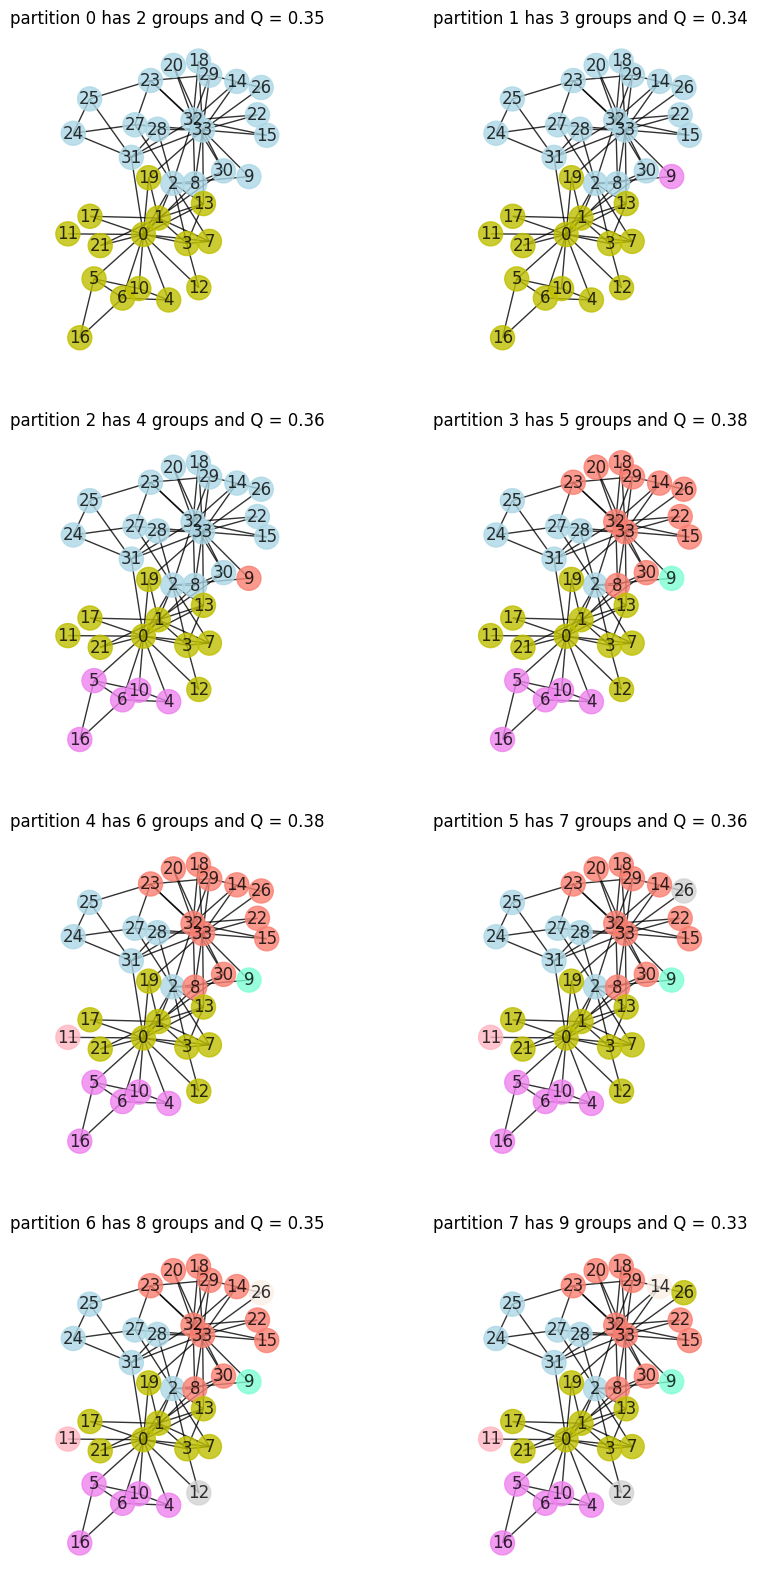

In [30]:
colors: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']

_, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(8): # Iterate through the first four groups
    node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
    for group_num in range(len(partition_list[i])):
        for node in partition_list[i][group_num]:
            node_group_dict[node] = group_num
    
    node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
    title: str = f"partition {i} "
    title = title + f"has {len(partition_list[i])} groups "
    title = title + f"and Q = {np.round(nx.community.modularity(karate_class, partition_list[i]),2)}"
    _ = show_graph(karate_class, 
                   node_color=node_colors, 
                   axes=axes[int(np.floor(i/2)), i%2],
                   title = title)

Observe two things about the plots
1. The change in modularity isn't simple. It starts at a value, goes down, and then goes back up.
2. Node 9 is put into its own group as soon as three groups are possible. That probably doesn't match your intuition, but it is correct given the greedy way that the Girvan-Newman partitioning algorithm handles edge betweenness.

---

#### Finding the partition with maximum modularity

If we search through each possible way that the graph can be partitioned into communities by the Girvan-Newman algoirthm, we can find the partition that maximizes modularity. Let's plot modularity as a function of the partition.

Text(0.5, 1.0, 'Modularity as a function of partition')

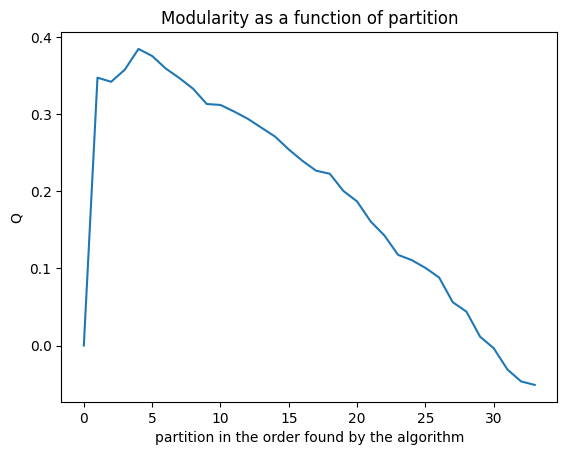

In [31]:
Q: list[float] = []
Q.append(nx.community.modularity(karate_class, (set(karate_class.nodes()),{}))) # Modularity of no partitions
for partition in partition_list:
    Q.append(nx.community.modularity(karate_class, partition))
_ = plt.plot(Q)
plt.xlabel('partition in the order found by the algorithm')
plt.ylabel('Q')
plt.title('Modularity as a function of partition')

Find the best partition

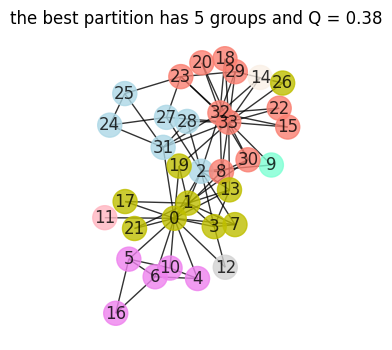

In [32]:
best_partition = max(partition_list, 
                     key=lambda partition: nx.community.modularity(karate_class, partition))

# Calculate the maximum Q value for reference
max_Q = nx.community.modularity(karate_class, best_partition)

node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[i])):
    for node in partition_list[i][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"the best partition has {len(best_partition)} groups "
title = title + f"and Q = {np.round(max_Q,2)}"
_ = show_graph(karate_class, 
                node_color=node_colors, 
                title = title)

---
---

#### Dendrogram

A dendrogram is a visualization tool that can provide insight into clustering. In the context of finding interesting communities in a network using the Girvan-Newman method, we are doing a form of clustering where we _divide_ the network into possible partitions and then select which partition we like most. 

The [tutorial found here](!https://www.data-to-viz.com/graph/dendrogram.html) provides a nice introduction to dendrograms.

---

Let's introduce the dendrogram in the context of a very simple graph.

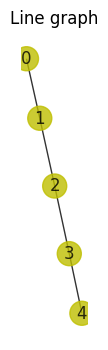

In [33]:
G: nx.Graph = nx.path_graph(5)
_ = show_graph(G, title="Line graph", plot_style = "SPRING")

We'll plot the dendrogram and then explore what it tells us.

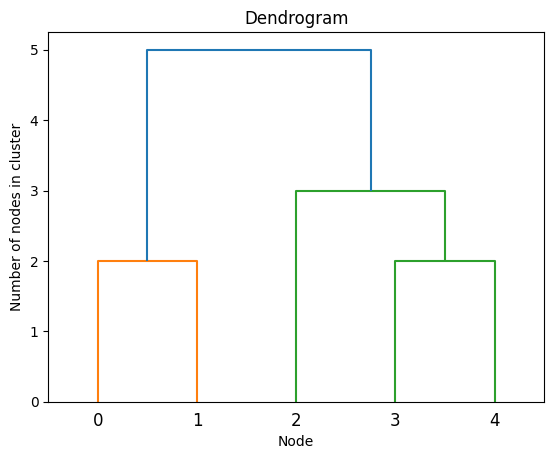

In [34]:
from dendrogram_handler_v2 import DendrogramHandler
from scipy.cluster.hierarchy import dendrogram # type: ignore

def show_dendrogram(G: nx.Graph,
                    title = "Dendrogram") -> None:
    plt.figure()
    myHandler: DendrogramHandler = DendrogramHandler(G)
    Z = myHandler.link_matrix       # Python style guides suggest direct access of public class variables
    ZLabels = myHandler.link_matrix_labels
    #plt.figure(figureNumber);plt.clf()
    dendrogram(Z, labels=ZLabels)
    plt.title(title)
    plt.xlabel("Node")
    plt.ylabel("Number of nodes in cluster")
    del myHandler

show_dendrogram(G)

Let's talk about what we are seeing. First, note that the labels on the x-axis correspond to vertices in the linegraph.

Second, let's look at all the possible partitions that can be produced when we run the Girvan-Newman algorithm. I'm going to call the sets in a partition a _group_, and define my own type for groups.


In [35]:
from typing import Set
Group = Set[Hashable]
all_partitions: list[Tuple[Group, ...]] = list(nx.algorithms.community.centrality.girvan_newman(G))
for i, partition in enumerate(all_partitions):
    print(f"partition {i} has sets {partition}")

partition 0 has sets ({0, 1}, {2, 3, 4})
partition 1 has sets ({0, 1}, {2}, {3, 4})
partition 2 has sets ({0}, {1}, {2}, {3, 4})
partition 3 has sets ({0}, {1}, {2}, {3}, {4})


Recall that the Girvan-Newman algorithm finds partitions by removing the iteratively computing edge betweenness and removing the edge with highest betweenness. Partition 0 is a tuple containing two sets
- {0, 1}
- {2, 3, 4}

These disjoint sets are formed when the edge between vertex 1 and vertex 2 is removed because that edge has the highest edge betweenness.

Partition 1 is a tuple containing three sets
- {0, 1}
- {2}
- {3, 4}

These mutually disjoint sets are formed when the edge between vertex 2 and vertex 3 is removed because that edge has the highest edge betweenness.

Partition 2 is formed when the edge between vertex 0 and vertex 1 is removed, and partition 3 is formed when the edge between vertex 3 and vertex 4 is removed.

These partitions are visualy displayed in the dendrogram. The top horizontal and vertical lines indicate the split of the network vertices into partition 0. Notice that the left side is connected to {0, 1} and the right side is connected to {2, 3, 4}. 

The next highest horizontal and vertical lines indicate the split of set {2, 3, 4} in to sets {2} and sets {3, 4}. The process continues. A line splitting into two other lines indicates the division of one of the sets into two new sets.

---

#### Dendrogram for the Karate Class Network

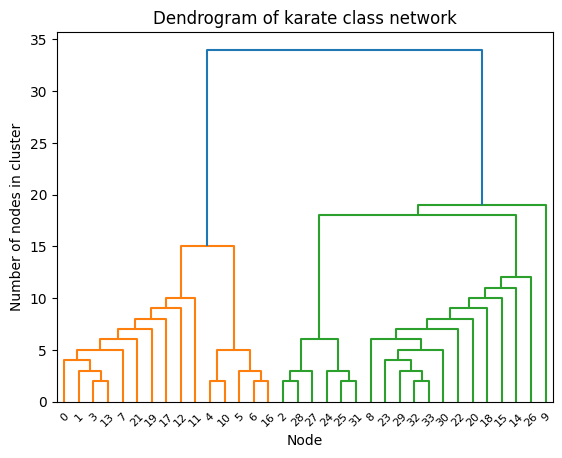

In [36]:
karate_class = nx.karate_club_graph()
show_dendrogram(karate_class, 
                title = "Dendrogram of karate class network")

The topmost part of the dendrogram shows that the vertices are separated into two disjoint sets. Let's check.

In [37]:
print(f"First group in first partition = \n\t{partition_list[0][0]}")
print(f"Second group in first partition = \n\t{partition_list[0][1]}")


First group in first partition = 
	{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
Second group in first partition = 
	{2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


That list of nodes matches up with the labels on the x-axis. 

Let's look at the next partition. The second partition is where vertex 9 gets "carved off" into its own group.

In [38]:
print(f"First group in second partition = \n\t{partition_list[1][0]}")
print(f"Second group in second partition = \n\t{partition_list[1][1]}")
print(f"Third group in second partition = \n\t{partition_list[1][2]}")


First group in second partition = 
	{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
Second group in second partition = 
	{32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Third group in second partition = 
	{9}


Let's repeat one more time so that we can see the groups after we split the vertices into four groups.

In [39]:
print(f"First group in third partition = \n\t{partition_list[2][0]}")
print(f"Second group in third partition = \n\t{partition_list[2][1]}")
print(f"Third group in third partition = \n\t{partition_list[2][2]}")
print(f"Fourth group in third partition = \n\t{partition_list[2][3]}")

First group in third partition = 
	{0, 1, 3, 7, 11, 12, 13, 17, 19, 21}
Second group in third partition = 
	{32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Third group in third partition = 
	{4, 5, 6, 10, 16}
Fourth group in third partition = 
	{9}


This split leads to an important subtlety about the dendrogram. We can use the dendrogram to help us divide a network into groups by drawing a horizontal line across it. 


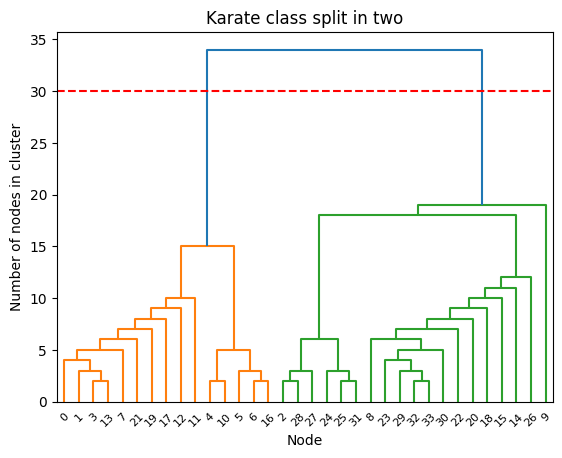

In [40]:
show_dendrogram(karate_class,
                title = "Karate class split in two")
_ = plt.axhline(y=30, color='r', linestyle='--')

Cutting the vertical lines at this point neatly divides the vertices into the first and second partitions. Let's repeat but with the line moved down.

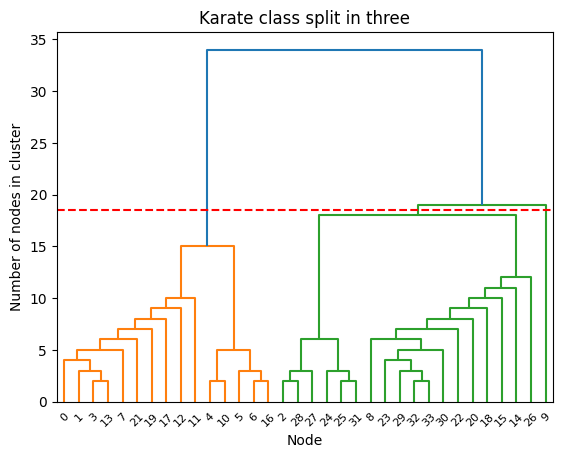

In [41]:
show_dendrogram(karate_class,
                title = "Karate class split in three")
_ = plt.axhline(y=18.5, color='r', linestyle='--')

This horizontal line splits the leftmost group into two, carving off node 9 into its own set. We can represent this by coloring the nodes like we did above.

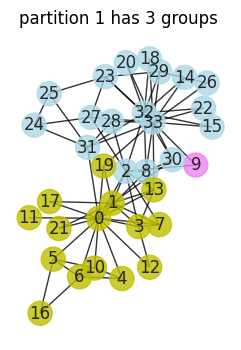

In [42]:
node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[1])):
    for node in partition_list[1][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"partition {1} "
title = title + f"has {len(partition_list[1])} groups "
_ = show_graph(karate_class, 
                node_color=node_colors,
                title = title)

Let's move the horizontal line down a bit and see what happens.

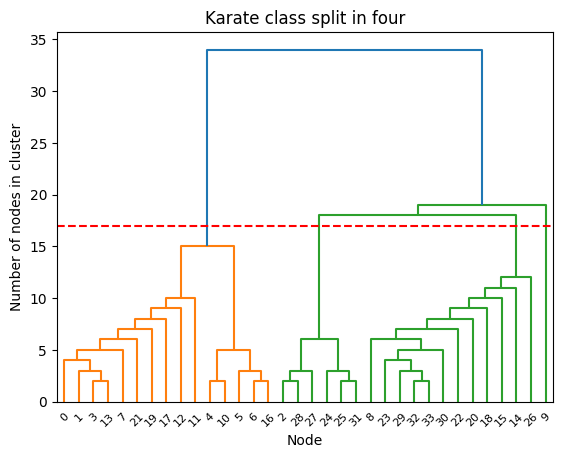

In [43]:
show_dendrogram(karate_class,
                title = "Karate class split in four")
_ = plt.axhline(y=17, color='r', linestyle='--')

We should now have four groups: 
- _First group_ = {0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
- _Second group_ = {2, 28, 27, 24, 25, 31}
- _Third group_ =  { 8, 23, 29, 32, 33, 30, 22, 20, 18, 15, 14, 26}
- _Fourth group_ = {9}

Let's color the nodes and see if this is correct.


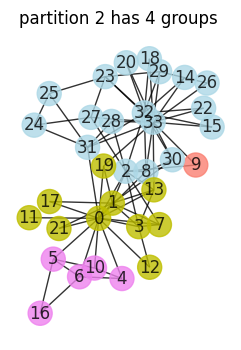

In [44]:
node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[2])):
    for node in partition_list[2][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"partition {2} "
title = title + f"has {len(partition_list[2])} groups "
_ = show_graph(karate_class, 
                node_color=node_colors,
                title = title)

The colors indicate that the Girvan-Newman algorithm actually split the vertices into the following four groups 
- _Group 1_ = {0, 1, 3, 7, 11, 12, 13, 17, 19, 21}
- _Group 2_ = {4, 5, 6, 10, 16}
- _Group 3_ = {2, 28, 27, 24, 25, 31, 8, 23, 29, 32, 33, 30, 22, 20, 18, 15, 14, 26}
- _Group 4_ = {9}


What happened?

Recall that the Girvan-Newman algorithm splits a set by removing the edge with highest betweenness. Unfortunately, the dendrogram sets the height of the places where a group splits in two proportional to the number of nodes in the set being split. Since the group

{2, 28, 27, 24, 25, 31, 8, 23, 29, 32, 33, 30, 22, 20, 18, 15, 14, 26}

has more nodes than the group

{0, 1, 3, 7, 11, 12, 13, 17, 19, 21, 4, 5, 6, 10, 16}

the split for the larger set is higher up in the dendrogram even though the split for the smaller set is obtained by removing the edge with highest edge betweenness. 

Thus, cutting the dendrogram at a given height creates groups by dividing the largest set first, which might be good but which is a different algorithm than what Girvan and Newman did.

---
---

#### Homework Problem 1

Create a network that has natural communities and find the partition that maximizes modularity. Use the dendrogram to build insight into what we mean when we say "natural communities".

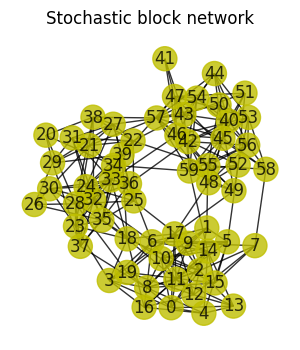

In [45]:
sizes = [20, 20, 20]
probs = [[0.35, 0.02, 0.02], [0.02, 0.35, 0.02], [0.02, 0.02, 0.40]]
G = nx.stochastic_block_model(sizes, probs, seed=42)
_ = show_graph(G, title = "Stochastic block network")

**Problem 1.a** Which partition does the plot of the network suggest will have the highest modularity? Why?

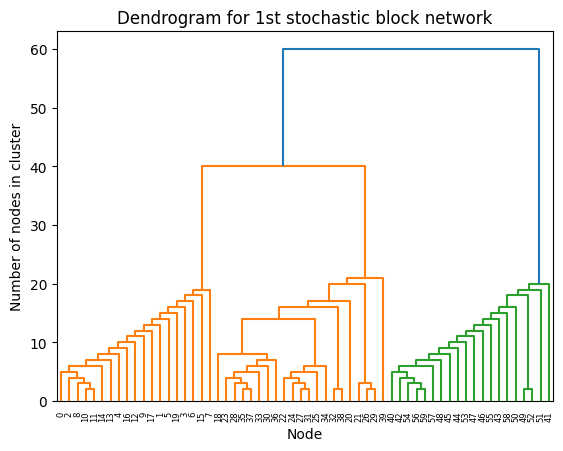

In [46]:
show_dendrogram(G, title = "Dendrogram for 1st stochastic block network")

**Problem 1.b** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 1.c** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?

---

#### Homework Problem 2

Create a network that has communities that aren't as obvious when we plot the network but that still has structure when we look at the dendrogram.

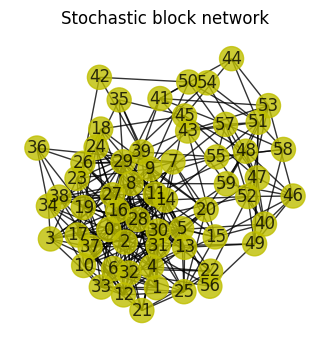

In [47]:
sizes = [20, 20, 20]
probs = [[0.25, 0.25, 0.05], [0.25, 0.25, 0.05], [0.05, 0.05, 0.25]]
G = nx.stochastic_block_model(sizes, probs, seed=42)
_ = show_graph(G, title = "Stochastic block network")

**Problem 2.a** Which partition does the plot of the network suggest will have the highest modularity? Why?

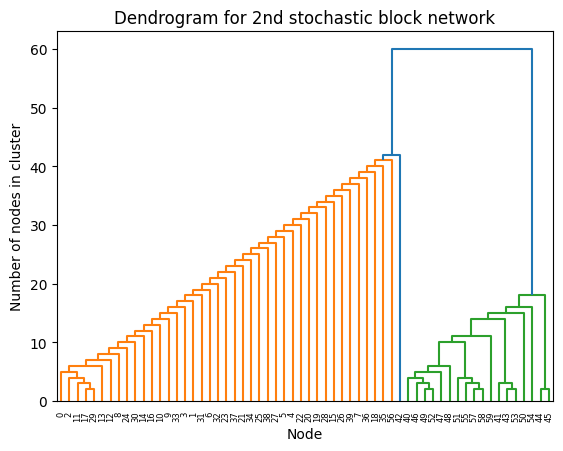

In [48]:
show_dendrogram(G, title = "Dendrogram for 2nd stochastic block network")

**Problem 2.b** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 2.c** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?

---

#### Homework Problem 3

Create a small-world network and explore partitioning.

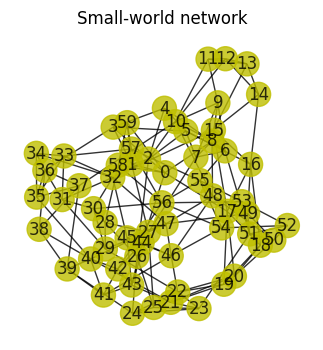

In [ ]:
G = nx.newman_watts_strogatz_graph(60, 4, 0.3, seed = 42)
_ = show_graph(G, title = "Small-world network", plot_style="SPRING")

**Problem 3.a** Which partition does the plot of the network suggest will have the highest modularity? Why?

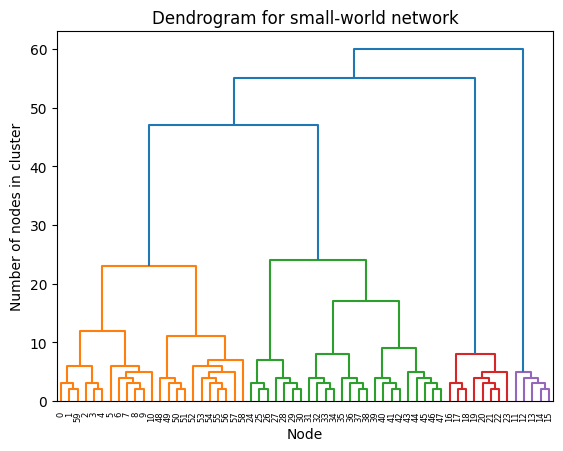

In [ ]:
show_dendrogram(G, title = "Dendrogram for small-world network")

**Problem 3.b** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 3.c** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?